<a href="https://colab.research.google.com/github/SUN-Wenjun/Advanced_Machine_Learning_Assignment/blob/master/Assignment2/AdvML_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced ML Assignment 2

Github repo: https://github.com/SUN-Wenjun/Advanced_Machine_Learning_Assignment/tree/master/Assignment2

In [0]:
import sys
import time
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications  import VGG19, ResNet50, InceptionV3

In [129]:
!unzip brain_tumor_dataset.zip  

Archive:  brain_tumor_dataset.zip
replace brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: brain_tumor_dataset/no/1 no.jpeg  
replace brain_tumor_dataset/no/10 no.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace brain_tumor_dataset/no/10 no.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# Extracting all filenames iteratively from brain_tumor_dataset folder
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) #examples of file names

number of images for each category: [155, 98]
[['brain_tumor_dataset/yes/Y11.jpg', 'brain_tumor_dataset/yes/Y248.JPG', 'brain_tumor_dataset/yes/Y114.JPG', 'brain_tumor_dataset/yes/Y52.jpg', 'brain_tumor_dataset/yes/Y243.JPG', 'brain_tumor_dataset/yes/Y182.JPG', 'brain_tumor_dataset/yes/Y184.JPG', 'brain_tumor_dataset/yes/Y112.JPG', 'brain_tumor_dataset/yes/Y41.jpg', 'brain_tumor_dataset/yes/Y254.jpg', 'brain_tumor_dataset/yes/Y59.JPG', 'brain_tumor_dataset/yes/Y89.JPG', 'brain_tumor_dataset/yes/Y244.JPG', 'brain_tumor_dataset/yes/Y195.JPG', 'brain_tumor_dataset/yes/Y4.jpg', 'brain_tumor_dataset/yes/Y185.jpg', 'brain_tumor_dataset/yes/Y92.png', 'brain_tumor_dataset/yes/Y15.jpg', 'brain_tumor_dataset/yes/Y21.jpg', 'brain_tumor_dataset/yes/Y13.jpg', 'brain_tumor_dataset/yes/Y251.JPG', 'brain_tumor_dataset/yes/Y192.JPG', 'brain_tumor_dataset/yes/Y116.JPG', 'brain_tumor_dataset/yes/Y86.JPG', 'brain_tumor_dataset/yes/Y104.jpg', 'brain_tumor_dataset/yes/Y102.jpg', 'brain_tumor_dataset/yes/Y12

In [3]:
# Let's explore the details of the image data using load_img from keras
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

img = load_img('brain_tumor_dataset/yes/Y26.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)

# It's an RGB image, so we can import using the following approach.

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(628, 630)


Using TensorFlow backend.


In [0]:
# Import image, load to array of shape height, width, channels, then min/max transform.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

# read in all images from filenames

preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1])) 

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model


In [5]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape 

253
(224, 224, 3)
0.0
1.0


(253, 224, 224, 3)

In [6]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))


#combine into single list of y labels
y_labels = yes+no

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

253


,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
248,1,0
249,1,0
250,1,0
251,1,0


## Q1 Visualize brain tumor images that demonstrate when images have tumors and when they do not have tumors.

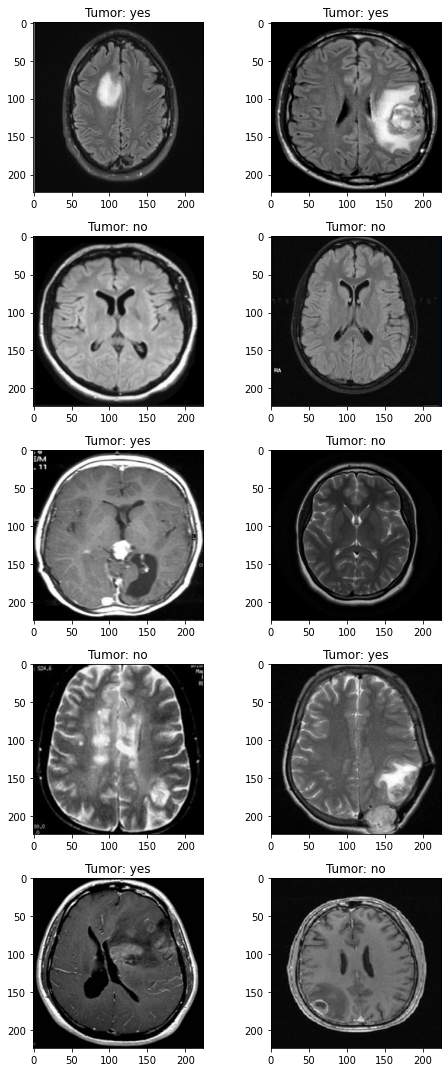

In [41]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(7,15)
for i in range(5):
    for j in range (2):
        l= np.random.randint(0,len(y_labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Tumor: '+y_labels[l])
        
plt.tight_layout()

From the images above we can see that, the brains with tumor have a obvious white area, while healthy brains don't. This difference enables us to use ML to classify brains with and without tumor. 

## Q2 Discuss why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

It is helpful to build a predictive model using this data because it can save doctors lots of time. Brain CT for a patient usually provides many images (i.e. different layers of brains), and we can let machine to go through these images first and provide doctors with the most 'suspicious' - 'tumor-liked' - images can be more effecient.

Doctor can benefit from this model because their time is saved. Patient can be benefit from it as well, as it's cheaper to have machine looks at the images than have a doctor do so, especially for patients in the area with a limited medical condition. 

## Q3 Run at least three prediction models to try to predict brain tumor MRI images well.

* Use transfer learning for at least one of these models
* Discuss which models performed better and point out relevant hyper-parameter values for successful models.

In [0]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

### Model 1

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adadelta
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint

with tf.device('/device:GPU:0'): 

      model = Sequential()
      model.add(Conv2D(32, kernel_size=(3,3),
                       activation='relu',
                       input_shape=(224, 224, 3)))
      model.add(Conv2D(64, (3,3), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2,2)))
      model.add(Dropout(0.25))
      model.add(Flatten())
      model.add(Dense(128, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(2, activation='softmax')) 

      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
      red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 20, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/20
6/7 [========================>.....] - ETA: 0s - loss: 0.6443 - accuracy: 0.6250
Epoch 00001: val_accuracy improved from -inf to 0.52941, saving model to best_model.h5
7/7 [==============================] - 14s 2s/step - loss: 0.6446 - accuracy: 0.6188 - val_loss: 0.6791 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 2/20
6/7 [========================>.....] - ETA: 0s - loss: 0.6210 - accuracy: 0.6354
Epoch 00002: val_accuracy did not improve from 0.52941
7/7 [==============================] - 0s 71ms/step - loss: 0.6246 - accuracy: 0.6386 - val_loss: 0.6774 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 3/20
6/7 [========================>.....] - ETA: 0s - loss: 0.5980 - accuracy: 0.6458
Epoch 00003: val_accuracy did not improve from 0.52941

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
7/7 [==============================] - 1s 71ms/step - loss: 0.6054 - accuracy: 0.6485 - val_loss: 0.6728 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 4/20
6/7 [========================

### Model 2

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adadelta
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint

with tf.device('/device:GPU:0'): 

      model = Sequential()
      model.add(Conv2D(16, kernel_size=(3,3),
                       activation='relu',
                       input_shape=(224, 224, 3)))
      model.add(MaxPooling2D(pool_size=(2,2)))
      model.add(Conv2D(32, (3,3), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2,2)))
      model.add(Conv2D(64, (3,3), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2,2)))
      model.add(Flatten())
      model.add(Dense(1024, activation='relu'))
      model.add(Dense(2, activation='softmax')) 

      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
      red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 100, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/100
5/7 [====================>.........] - ETA: 0s - loss: 0.6916 - accuracy: 0.5000
Epoch 00001: val_accuracy improved from -inf to 0.56863, saving model to best_model.h5
7/7 [==============================] - 2s 276ms/step - loss: 0.6904 - accuracy: 0.5050 - val_loss: 0.6844 - val_accuracy: 0.5686 - lr: 0.0010
Epoch 2/100
5/7 [====================>.........] - ETA: 0s - loss: 0.6661 - accuracy: 0.6562
Epoch 00002: val_accuracy did not improve from 0.56863
7/7 [==============================] - 0s 33ms/step - loss: 0.6615 - accuracy: 0.6535 - val_loss: 0.6771 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.6485
Epoch 00003: val_accuracy did not improve from 0.56863

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
7/7 [==============================] - 0s 35ms/step - loss: 0.6439 - accuracy: 0.6485 - val_loss: 0.6729 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 4/100
5/7 [==================

### Model 3

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      model = Sequential()
      model.add(Dense(64,  input_shape=(224, 224, 3), activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax')) 

  
      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
      red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 20, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.6238
Epoch 00001: val_accuracy improved from -inf to 0.72549, saving model to best_model.h5
7/7 [==============================] - 1s 153ms/step - loss: 0.6288 - accuracy: 0.6238 - val_loss: 0.6335 - val_accuracy: 0.7255 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.7178
Epoch 00002: val_accuracy did not improve from 0.72549
7/7 [==============================] - 1s 130ms/step - loss: 0.5458 - accuracy: 0.7178 - val_loss: 0.6338 - val_accuracy: 0.7255 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.7921
Epoch 00003: val_accuracy did not improve from 0.72549

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
7/7 [==============================] - 1s 128ms/step - loss: 0.5103 - accuracy: 0.7921 - val_loss: 0.6671 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/20
7/7 [====================

In [9]:
model.history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

### Discuss which models performed better and point out relevant hyper-parameter values for successful models.

Model 3 performed best among the three models. Its hyper-parameters include:

* 5 layers (3 hidden layers, each with 64 units) 
* learning rate: dividing learning rate by 10 when val_accuracy fails to improve after 3 epochs
* maximum number of epochs: 20, so the entire training set pass through the neural network for at most 20 times. 
* activation function: rectifier except for the output layer, i.e. output the input directly if is positive, otherwise, it will output zero.

## Submit your best model to the leader board for the Brain Tumor Diagnostic AI Model Share competition.

In [10]:
# Load libraries for onnx model conversion (keras to onnx)
! pip3 install keras2onnx
! pip3 install onnxruntime

In [19]:
import os
os.environ['TF_KERAS'] = '1' # Add this environmental variable whenever you use tensorflow's tf.keras to build your keras model
import onnx

import keras2onnx

from keras2onnx import convert_keras
onx = convert_keras(model, 'my_model.onnx')
with open("my_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

The maximum opset needed by this model is only 9.


In [21]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

raw_predictions=model.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1
 1 0 1 1 0 1 0 1 1 1 1 0 1 0]
['no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no']


In [0]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata



In [23]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.784314,0.778873,0.796053,0.777778,0,0,0,0


In [24]:
# add metrics to submittable object
modelevalobject=model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")


modelevalobject# add metrics to submittable object


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.784314,0.778873,0.796053,0.777778,0,0,0,0


In [25]:
#install aimodelshare library (version 0.0.3 last updated 3/6/2020)
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true

  Using cached https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true
  Created wheel for aimodelshare: filename=aimodelshare-0.0.5-cp36-none-any.whl size=5305 sha256=6b8d724d641661345e0f1a7ac67719310e8363a9814392110c6edd5b601497ac
  Stored in directory: /root/.cache/pip/wheels/ab/28/ae/b9ecb7a3a5542d3f2fed56649fdd6dec1c16f900ef70b93875
Successfully built aimodelshare


In [0]:
username = ""
password = ""

In [0]:
# Example Model Pre-launched into Model Share Site
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
model_filepath="my_model.onnx"   

# New! Assign model object to model argument parameter to submit model architecture to leaderboard.
model=model

# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.

import pickle
aws_key_password_region = pickle.load( open( "braintumor_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [0]:
model.history.epoch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] # although we were able to call this attribute earlier, it lost at somewhere afterwards, so I added it back manually here 

In [30]:
# Submit your model using submit_model() function
# Works with models and preprocessors. 
import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject,modelobject=model,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata="default",preprocessor_filepath="default",preprocessor="default")


"my_model.onnx" has been loaded to version 14 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


## Import the best model from the leader board (whatever the best model is after your final submission)

* Import the model's config and it's optimization config.
* Visualize the model's structure using tf.kera's model.summary() 

In [0]:
# arguments required to get leaderboard below
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"

In [32]:
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
12,0.784314,0.778873,0.796053,0.777778,0,0,0,0,SUN-Wenjun,14,1.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",20
3,0.784314,0.775690,0.808824,0.775463,0,0,0,0,username1,5,1.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
6,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,8,1.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
7,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,9,1.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
8,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,10,1.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
5,0.764706,0.757143,0.780303,0.756944,0,0,0,0,username1,7,3.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
0,0.745098,0.730159,0.780556,0.733796,0,0,0,0,username1,2,4.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",5
11,0.745098,0.743520,0.744565,0.743056,0,0,0,0,SUN-Wenjun,13,5.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",20
4,0.725490,0.720219,0.729839,0.719907,0,0,0,0,username1,6,6.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
10,0.705882,0.701754,0.707143,0.701389,0,0,0,0,SUN-Wenjun,12,7.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


The best model as of now is mine, yeah!

In [33]:
# Import and print model details from leaderboard
model_config= leaderboard.loc[0,'model_config'] # model details best model (i.e.-row #1)
model_optim_config= leaderboard.loc[0,'model_optim_config'] # model details best model (i.e.-row #1)

print(model_config)
print(model_optim_config)

backend: tensorflow
class_name: Sequential
config:
  layers:
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}
      kernel_regularizer: null
      name: dense
      trainable: true
      units: 64
      use_bias: true
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}

In [34]:
# Import model config to use to fit same architecture to new data
from tensorflow.keras.models import model_from_yaml
model = model_from_yaml(model_config)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224, 224, 64)      256       
_________________________________________________________________
dense_1 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
dense_2 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
flatten (Flatten)            (None, 3211264)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6422530   
Total params: 6,431,106
Trainable params: 6,431,106
Non-trainable params: 0
_________________________________________________________________


* Explain how the model's structure is different from your best model.
* Explain how the model's optimization approach is different from your best model

It **is** my best model, so there is no difference. 

## Fit the best model from the leader board to training data and evaluate it on test data to complete your report.

To do this question, I'll use another model that is not mine and fit that model.

In [35]:
# Import and print model details from leaderboard
model_config= leaderboard.loc[1,'model_config'] # model details best model (i.e.-row #1)
model_optim_config= leaderboard.loc[1,'model_optim_config'] # model details best model (i.e.-row #1)

print(model_config)
print(model_optim_config)

backend: tensorflow
class_name: Sequential
config:
  layers:
  - class_name: Conv2D
    config:
      activation: relu
      activity_regularizer: null
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      data_format: channels_last
      dilation_rate: &id001 !!python/tuple [1, 1]
      dtype: float32
      filters: 32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}
      kernel_regularizer: null
      kernel_size: !!python/tuple [3, 3]
      name: conv2d
      padding: same
      strides: &id002 !!python/tuple [1, 1]
      trainable: true
      use_bias: true
  - class_name: Conv2D
    config:
      activation: relu
      activity_regularizer: null
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: 

In [36]:
# Import model config to use to fit same architecture to new data
from tensorflow.keras.models import model_from_yaml
model = model_from_yaml(model_config)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      1056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 32)       

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [46]:
# fit the model on training data
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(X_train, y_train, 
            epochs = 5, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.6337
Epoch 00001: val_accuracy did not improve from 0.78431
7/7 [==============================] - 0s 56ms/step - loss: 0.6802 - accuracy: 0.6337 - val_loss: 0.6885 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 2/5
7/7 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.6337
Epoch 00002: val_accuracy did not improve from 0.78431
7/7 [==============================] - 0s 37ms/step - loss: 0.6757 - accuracy: 0.6337 - val_loss: 0.6885 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 3/5
7/7 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.6337
Epoch 00003: val_accuracy did not improve from 0.78431

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
7/7 [==============================] - 0s 40ms/step - loss: 0.6744 - accuracy: 0.6337 - val_loss: 0.6884 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 4/5
7/7 [==============================] - ETA: 0s - loss: 0.6768 - 

In [50]:
# using predict_classes() for multi-class data to return predicted class index.
raw_predictions=model.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']


In [51]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.529412,0.346154,0.264706,0.5,0,0,0,0
